<a href="https://colab.research.google.com/github/ParvinGhaffarzadeh/MrGBP/blob/master/CNN_emotion_recognition_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Importing the required libraries

In [ ]:


## Python
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

In [ ]:
import IPython
import tdutils

In [ ]:
IPython.display.Audio("C:/Users/asus/PycharmProjects/pythonProject1/emotion_recognition_cnn-master/emotion_recognition_cnn-master/Data/Actor_03/03-01-01-01-01-01-03.wav")

# II. Reading the data

In [ ]:
# Data Directory
# Please edit according to your directory change.
!wget https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio
dir_list = os.listdir('C:/Users/asus/PycharmProjects/pythonProject1/emotion_recognition_cnn-master/emotion_recognition_cnn-master/Data')
dir_list.sort()
print (dir_list)

--2021-04-28 15:57:11--  https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘ravdess-emotional-speech-audio’

ravdess-emotional-s     [ <=>                ]  60.73K  --.-KB/s    in 0.1s    

2021-04-28 15:57:12 (455 KB/s) - ‘ravdess-emotional-speech-audio’ saved [62186]



FileNotFoundError: ignored

In [ ]:
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0

In [ ]:
data_df.head(-5)

,path,source,actor,gender,intensity,statement,repetition,emotion


In [ ]:
nm1 = f.split('.')[0].split('-')
print(nm1)

['03', '01', '08', '02', '02', '02', '24']


In [ ]:
# Create DataFrame for Data intel
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('C:/Users/asus/PycharmProjects/pythonProject1/emotion_recognition_cnn-master/emotion_recognition_cnn-master/Data/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = 'C:/Users/asus/PycharmProjects/pythonProject1/emotion_recognition_cnn-master/emotion_recognition_cnn-master/Data/' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [ ]:
print (len(data_df))
data_df.head()

1440


,path,source,actor,gender,intensity,statement,repetition,emotion
0,C:/Users/asus/PycharmProjects/pythonProject1/e...,1,1,male,0,0,0,1
1,C:/Users/asus/PycharmProjects/pythonProject1/e...,1,1,male,0,0,1,1
2,C:/Users/asus/PycharmProjects/pythonProject1/e...,1,1,male,0,1,0,1
3,C:/Users/asus/PycharmProjects/pythonProject1/e...,1,1,male,0,1,1,1
4,C:/Users/asus/PycharmProjects/pythonProject1/e...,1,1,male,0,0,0,2


# III. Plotting the audio file's waveform and its spectrogram

In [ ]:
filename = data_df.path[1021]
print (filename)

C:/Users/asus/PycharmProjects/pythonProject1/emotion_recognition_cnn-master/emotion_recognition_cnn-master/Data/Actor_18/03-01-01-01-01-02-18.wav


In [ ]:
samples, sample_rate = librosa.load(filename)

In [ ]:
filename = data_df.path[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

C:/Users/asus/PycharmProjects/pythonProject1/emotion_recognition_cnn-master/emotion_recognition_cnn-master/Data/Actor_18/03-01-01-01-01-02-18.wav


(22050, array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [ ]:
len(samples), sample_rate

(77989, 22050)

In [ ]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


In [ ]:
sample_rate/ len(samples)

0.28273218017925605

Text(0.5, 0, 'Seconds')

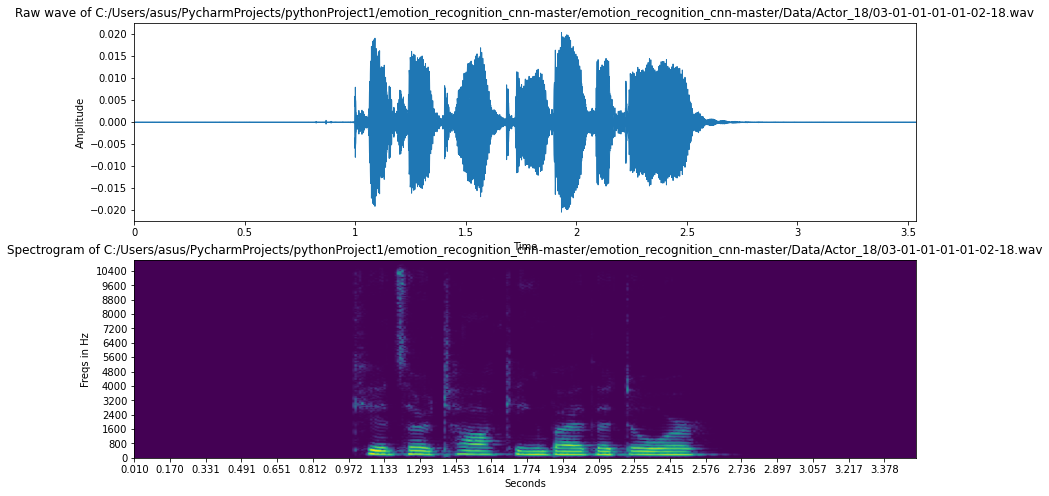

In [ ]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [ ]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [ ]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([-1.9141038e-07, -4.1607140e-07,  2.0688096e-06, ...,
         5.6699279e-05,  2.1195672e-05,  3.1794041e-06], dtype=float32),
 array([20992, 58880]))

C:\Pythonn\Anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning:

The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.

C:\Pythonn\Anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning:

The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



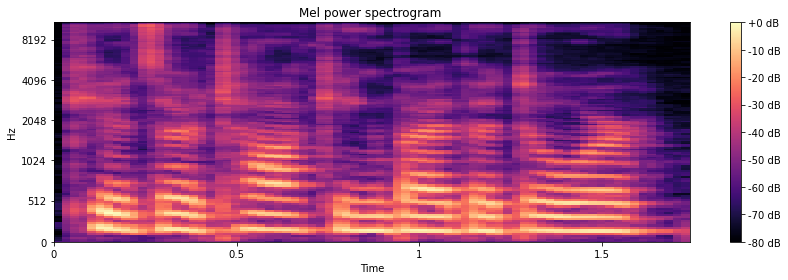

In [ ]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

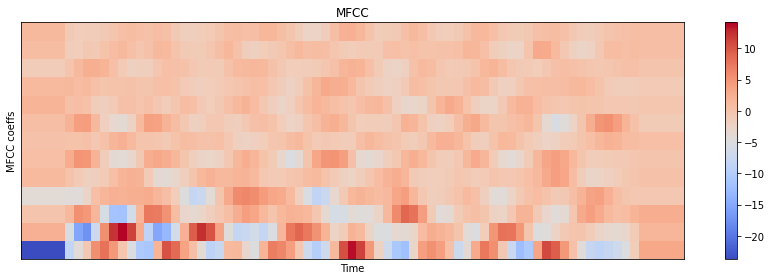

In [ ]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [ ]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [ ]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [ ]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

# IV. Defining the truth label

In [ ]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)

1440

In [ ]:
#3 class: Positive, Neutral & Negative

# Positive:  Happy
# Negative: Angry, Fearful, Sad
# Neutral: Calm, Neutral

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

1440

In [ ]:
# 5 class: angry, calm, sad, happy & fearful
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

1440

In [ ]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

1440

In [ ]:
# Select the label set you want by commenting the unwanteds.

data_df['label'] = label2_list
# data_df['label'] = label3_list
# data_df['label'] = label5_list
# data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,C:/Users/asus/PycharmProjects/pythonProject1/e...,1,1,male,0,0,0,1,male_none
1,C:/Users/asus/PycharmProjects/pythonProject1/e...,1,1,male,0,0,1,1,male_none
2,C:/Users/asus/PycharmProjects/pythonProject1/e...,1,1,male,0,1,0,1,male_none
3,C:/Users/asus/PycharmProjects/pythonProject1/e...,1,1,male,0,1,1,1,male_none
4,C:/Users/asus/PycharmProjects/pythonProject1/e...,1,1,male,0,0,0,2,male_positive


In [ ]:
print (data_df.label.value_counts().keys())

Index(['male_negative', 'female_negative', 'female_none', 'male_none',
       'female_positive', 'male_positive'],
      dtype='object')


In [ ]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

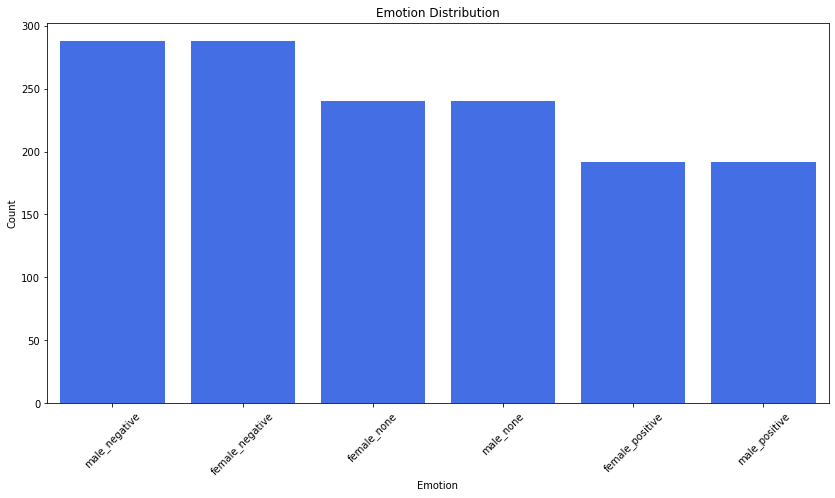

In [ ]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

# V. Data Splitting

In [ ]:
# Female Data Set

## Uncomment all below to use Female set 

# data2_df = data_df.copy()
# data2_df = data2_df[data2_df.label != "male_none"]
# data2_df = data2_df[data2_df.label != "female_none"]
# data2_df = data2_df[data2_df.label != "male_happy"]
# data2_df = data2_df[data2_df.label != "male_angry"]
# data2_df = data2_df[data2_df.label != "male_sad"]
# data2_df = data2_df[data2_df.label != "male_fearful"]
# data2_df = data2_df[data2_df.label != "male_calm"]
# data2_df = data2_df[data2_df.label != "male_positive"]
# data2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)

# tmp1 = data2_df[data2_df.actor == 22]
# tmp2 = data2_df[data2_df.actor == 24]
# data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)
# data2_df = data2_df[data2_df.actor != 22]
# data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
# print (len(data2_df))
# data2_df.head()

In [ ]:
# Male Data Set

## Uncomment all below to use Male set 

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

400


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,C:/Users/asus/PycharmProjects/pythonProject1/e...,1,1,male,0,0,0,2,male_positive
1,C:/Users/asus/PycharmProjects/pythonProject1/e...,1,1,male,0,0,1,2,male_positive
2,C:/Users/asus/PycharmProjects/pythonProject1/e...,1,1,male,0,1,0,2,male_positive
3,C:/Users/asus/PycharmProjects/pythonProject1/e...,1,1,male,0,1,1,2,male_positive
4,C:/Users/asus/PycharmProjects/pythonProject1/e...,1,1,male,1,0,0,2,male_positive


In [ ]:
print (len(data3_df))
data3_df.head()

80


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,C:/Users/asus/PycharmProjects/pythonProject1/e...,1,21,male,0,0,0,2,male_positive
1,C:/Users/asus/PycharmProjects/pythonProject1/e...,1,21,male,0,0,1,2,male_positive
2,C:/Users/asus/PycharmProjects/pythonProject1/e...,1,21,male,0,1,0,2,male_positive
3,C:/Users/asus/PycharmProjects/pythonProject1/e...,1,21,male,0,1,1,2,male_positive
4,C:/Users/asus/PycharmProjects/pythonProject1/e...,1,21,male,1,0,0,2,male_positive


# VI. Getting the features of audio files using librosa

In [ ]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:49<00:00,  8.11it/s]


In [ ]:
data.head()

,feature
0,"[-70.26777, -70.26777, -70.26777, -70.26777, -..."
1,"[-67.55739, -67.55739, -67.55739, -67.55739, -..."
2,"[-69.67329, -69.693306, -69.693306, -69.693306..."
3,"[-69.0514, -69.0514, -69.0514, -69.0514, -69.0..."
4,"[-73.84137, -73.84137, -73.84137, -73.71965, -..."


In [ ]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [ ]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-70.267769,-69.957710,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769
1,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,...,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.126572,-67.557388
2,-69.673286,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.620773,-69.693306,-68.906570,...,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.383514,-69.693306,-69.693306,-69.693306,-69.693306
3,-69.051399,-69.051399,-69.051399,-69.051399,-69.051399,-68.754860,-69.051399,-69.051399,-69.051399,-68.359085,...,-65.446953,-68.552094,-69.051399,-69.051399,-69.051399,-68.688614,-69.051399,NaN,NaN,NaN
4,-73.841370,-73.841370,-73.841370,-73.719650,-73.841370,-73.841370,-73.841370,-73.303635,-72.806808,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370


In [ ]:
newdf = pd.concat([df3,labels], axis=1)

In [ ]:
newdf.head(-5)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-69.957710,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769,male_positive
1,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,...,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.126572,-67.557388,male_positive
2,-69.673286,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.620773,-69.693306,-68.906570,...,-69.693306,-69.693306,-69.693306,-69.693306,-69.383514,-69.693306,-69.693306,-69.693306,-69.693306,male_positive
3,-69.051399,-69.051399,-69.051399,-69.051399,-69.051399,-68.754860,-69.051399,-69.051399,-69.051399,-68.359085,...,-68.552094,-69.051399,-69.051399,-69.051399,-68.688614,-69.051399,NaN,NaN,NaN,male_positive
4,-73.841370,-73.841370,-73.841370,-73.719650,-73.841370,-73.841370,-73.841370,-73.303635,-72.806808,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,male_positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,-37.782722,-37.787117,-38.029518,-38.042484,-37.303856,-37.690720,-37.845879,-38.012836,-37.955795,-37.609169,...,-25.694426,-28.186331,-29.130754,-29.848602,-30.318237,-33.560627,-34.570389,-34.106979,-34.701767,male_negative
391,-46.687786,-46.687786,-46.687786,-46.687786,-46.687786,-46.687786,-46.687786,-46.687786,-46.687786,-46.687786,...,-42.999535,-44.230625,-43.702251,-44.292034,-43.527222,-43.012089,-43.495468,-44.797756,-45.223244,male_negative
392,-53.184605,-51.684162,-50.400539,-49.040108,-49.004330,-49.252640,-49.219246,-49.728661,-52.532028,-52.471367,...,-50.207008,-49.862141,-49.074471,-49.553177,-51.913200,-51.675846,-51.333393,-51.080631,-51.929001,male_negative
393,-64.818512,-64.818512,-62.839226,-61.646175,-61.751812,-61.417263,-60.464653,-62.012203,-64.297478,-64.105843,...,-50.248047,-48.743523,-48.019066,-46.892536,-45.303322,-45.000549,-46.153625,-47.801167,-47.905281,male_negative


In [ ]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

400

In [ ]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-69.957710,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769,male_positive
1,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,...,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.126572,-67.557388,male_positive
2,-69.673286,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.620773,-69.693306,-68.906570,...,-69.693306,-69.693306,-69.693306,-69.693306,-69.383514,-69.693306,-69.693306,-69.693306,-69.693306,male_positive
3,-69.051399,-69.051399,-69.051399,-69.051399,-69.051399,-68.754860,-69.051399,-69.051399,-69.051399,-68.359085,...,-68.552094,-69.051399,-69.051399,-69.051399,-68.688614,-69.051399,NaN,NaN,NaN,male_positive
4,-73.841370,-73.841370,-73.841370,-73.719650,-73.841370,-73.841370,-73.841370,-73.303635,-72.806808,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,male_positive
5,-69.243256,-69.243256,-69.243256,-69.243256,-68.901970,-67.983002,-68.089203,-67.897331,-65.258011,-67.170975,...,-57.185970,-61.188725,-67.108391,-67.508125,-66.245537,-68.733047,-69.243256,-69.243256,-69.243256,male_positive
6,-73.254967,-73.254967,-73.254967,-73.254967,-68.774429,-69.380402,-73.254967,-73.254967,-73.254967,-73.254967,...,-50.884087,-55.666733,-54.600002,-53.439114,-56.300125,-57.458267,-58.767071,-59.836510,-58.409870,male_positive
7,-70.746513,-70.746513,-70.025284,-69.131271,-70.746513,-70.746513,-70.746513,-70.746513,-70.746513,-70.746513,...,-70.746513,-70.746513,-70.079247,-69.590454,-69.202751,-70.159462,-70.445366,-68.199043,-67.414200,male_positive
8,-63.311062,-63.072487,-63.412422,-63.796757,-63.581989,-58.921223,-57.955044,-61.224972,-63.782932,-63.796757,...,-63.740608,-62.410255,-62.489079,-62.494453,-62.632626,-62.824276,NaN,NaN,NaN,male_positive
9,-60.369045,-60.083717,-60.978924,-60.952457,-60.982483,-60.983948,-60.981255,-60.981255,-60.981255,-60.249615,...,-60.981255,-60.981255,-60.981255,-60.981255,-60.981255,-60.981255,NaN,NaN,NaN,male_positive


In [ ]:
rnewdf.isnull().sum().sum()

2284

In [ ]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-69.957710,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769,male_positive
1,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,...,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.126572,-67.557388,male_positive
2,-69.673286,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.620773,-69.693306,-68.906570,...,-69.693306,-69.693306,-69.693306,-69.693306,-69.383514,-69.693306,-69.693306,-69.693306,-69.693306,male_positive
3,-69.051399,-69.051399,-69.051399,-69.051399,-69.051399,-68.754860,-69.051399,-69.051399,-69.051399,-68.359085,...,-68.552094,-69.051399,-69.051399,-69.051399,-68.688614,-69.051399,0.000000,0.000000,0.000000,male_positive
4,-73.841370,-73.841370,-73.841370,-73.719650,-73.841370,-73.841370,-73.841370,-73.303635,-72.806808,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,male_positive


# VII. Data Augmentation

In [ ]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data




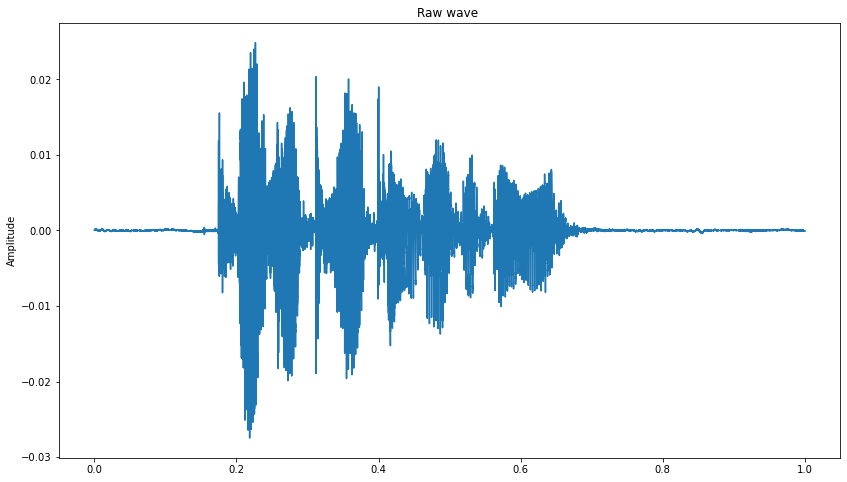

In [ ]:
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

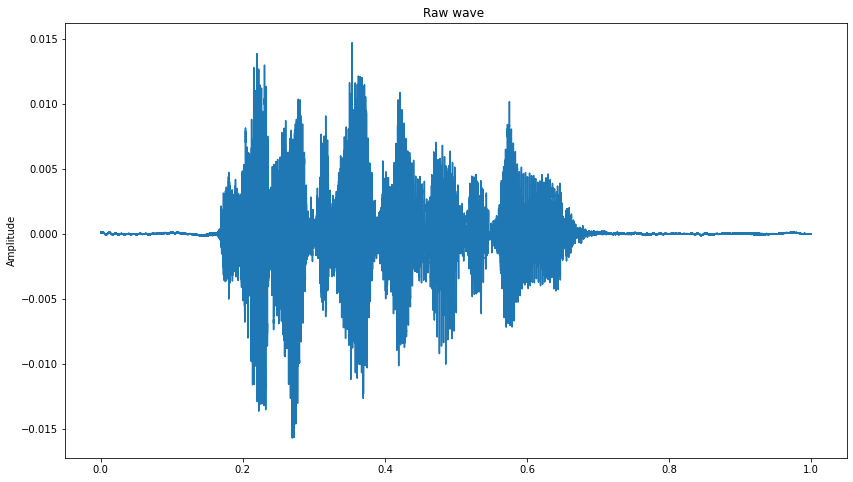

In [ ]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [ ]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]
        

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:00<00:00,  6.57it/s]


In [ ]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]
        

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [04:58<00:00,  1.34it/s]


In [ ]:
len(syn_data1), len(syn_data2) 

(400, 400)

In [ ]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [ ]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

400

In [ ]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-65.045640,-63.167783,-63.464077,-62.233948,-61.749767,-61.927781,-63.040665,-63.124893,-64.575200,-65.547293,...,-64.284903,-62.168541,-60.957140,-60.482111,-59.385687,-60.054099,-61.433854,-65.444602,-67.929614,male_positive
1,-59.862549,-58.614966,-57.713133,-57.375348,-58.493607,-61.197269,-60.120811,-59.274716,-60.191114,-58.338759,...,-58.272186,-57.762127,-59.080305,-60.111074,-61.892269,-59.801353,-61.481732,-62.486437,-62.844528,male_positive
2,-63.267949,-64.792223,-68.624772,-66.215489,-65.795479,-67.786218,-67.873196,-67.209948,-65.951186,-63.967243,...,-67.899517,-66.899842,-66.803892,-66.282091,-65.710738,-66.389170,-66.591924,-65.247039,-67.693253,male_positive
3,-61.995705,-59.938669,-58.307679,-59.114949,-57.739604,-56.460380,-60.145600,-56.342282,-53.567533,-56.342107,...,-55.105617,-56.059786,-56.634014,-59.401442,-59.615679,-55.773068,0.000000,0.000000,0.000000,male_positive
4,-69.339313,-68.410027,-70.532904,-70.601279,-68.355351,-68.730394,-68.315541,-67.691217,-68.904730,-69.592185,...,-69.733148,-68.915798,-68.724011,-68.449476,-68.429894,-65.811546,-64.722005,-65.235261,-69.128536,male_positive


In [ ]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

400

In [ ]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-72.095055,-72.095055,-72.095055,-72.095055,-72.095055,-72.095055,-72.095055,-72.095055,-72.095055,-72.095055,...,-72.095055,-72.095055,-72.047995,-71.451466,-72.095055,-71.742142,-71.662088,-72.095055,-72.095055,male_positive
1,-70.901134,-70.892825,-70.791593,-70.901134,-70.901134,-69.898179,-69.150567,-70.627450,-70.901134,-70.901134,...,-70.901134,-70.901134,-70.901134,-70.901134,-70.901134,-70.901134,-70.901134,-70.901134,-70.721099,male_positive
2,-70.765406,-71.161753,-71.218540,-71.218540,-71.218540,-71.218540,-71.218540,-71.218540,-71.147892,-70.794085,...,-71.218540,-71.218540,-71.218540,-71.218540,-71.218540,-71.218540,-71.218540,-71.218540,-71.218540,male_positive
3,-70.718967,-70.718967,-70.718967,-70.718967,-70.718967,-70.718967,-70.718967,-70.718967,-70.718967,-70.636607,...,-69.260788,-70.718967,-70.718967,-70.718967,-70.718967,-70.718967,0.000000,0.000000,0.000000,male_positive
4,-74.276880,-74.276880,-74.276880,-74.276880,-74.276880,-74.276880,-74.276880,-74.096962,-74.197259,-74.276880,...,-74.276880,-74.276880,-74.276880,-74.276880,-74.276880,-74.276880,-74.276880,-74.276880,-74.276880,male_positive


In [ ]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-69.957710,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769,male_positive
1,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,...,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.126572,-67.557388,male_positive
2,-69.673286,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.620773,-69.693306,-68.906570,...,-69.693306,-69.693306,-69.693306,-69.693306,-69.383514,-69.693306,-69.693306,-69.693306,-69.693306,male_positive
3,-69.051399,-69.051399,-69.051399,-69.051399,-69.051399,-68.754860,-69.051399,-69.051399,-69.051399,-68.359085,...,-68.552094,-69.051399,-69.051399,-69.051399,-68.688614,-69.051399,0.000000,0.000000,0.000000,male_positive
4,-73.841370,-73.841370,-73.841370,-73.719650,-73.841370,-73.841370,-73.841370,-73.303635,-72.806808,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,male_positive


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
#  Stratified Shuffle Split

X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
y_train.value_counts()

male_negative    576
male_positive    384
Name: label, dtype: int64

In [ ]:
y_test.value_counts()

male_negative    144
male_positive     96
Name: label, dtype: int64

In [ ]:
X_train.isna().sum().sum()

0

# one_hot categorical - preprocess class labels

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
y_train.shape

(960, 2)

In [ ]:
X_train.shape

(960, 259)

In [ ]:
y_test.shape

(240, 2)

In [ ]:
X_test.shape

(240, 259)

# VIII. Changing dimension for CNN model

In [ ]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [ ]:
x_traincnn.shape

(960, 259, 1)

In [ ]:
x_testcnn.shape

(240, 259, 1)

In [ ]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr



In [ ]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(2))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)


In [ ]:
# Original Model

model = Sequential()
model.add(Conv1D(256, 5,padding='same', input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(5))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)


In [ ]:
# Plotting Model Summary

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_58 (Conv1D)           (None, 259, 256)          2304      
_________________________________________________________________
activation_67 (Activation)   (None, 259, 256)          0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 259, 256)          524544    
_________________________________________________________________
batch_normalization_4 (Batch (None, 259, 256)          1024      
_________________________________________________________________
activation_68 (Activation)   (None, 259, 256)          0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 259, 256)          0         
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 32, 256)          

In [ ]:
# Compiled model    optimizer='rmsprop' فراخوانی مدل

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
cnnhistory= model.fit(x_traincnn, y_train, epochs=30, batch_size=16, 
                     validation_data=(x_testcnn, y_test))

Epoch 1/30
60/60 [==============================] - 38s 625ms/step - loss: 0.7600 - accuracy: 0.4979 - val_loss: 0.7004 - val_accuracy: 0.4250
Epoch 2/30
60/60 [==============================] - 38s 627ms/step - loss: 0.6547 - accuracy: 0.6125 - val_loss: 0.6896 - val_accuracy: 0.5500
Epoch 3/30
60/60 [==============================] - 37s 613ms/step - loss: 0.6355 - accuracy: 0.6333 - val_loss: 0.6806 - val_accuracy: 0.6375
Epoch 4/30
60/60 [==============================] - 36s 605ms/step - loss: 0.6175 - accuracy: 0.6594 - val_loss: 0.6784 - val_accuracy: 0.5833
Epoch 5/30
60/60 [==============================] - 38s 630ms/step - loss: 0.6050 - accuracy: 0.6573 - val_loss: 0.6625 - val_accuracy: 0.6792
Epoch 6/30
60/60 [==============================] - 38s 628ms/step - loss: 0.6028 - accuracy: 0.6812 - val_loss: 0.6513 - val_accuracy: 0.6708
Epoch 7/30
60/60 [==============================] - 36s 605ms/step - loss: 0.6022 - accuracy: 0.6792 - val_loss: 0.6391 - val_accuracy: 0.6500

In [ ]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]

In [ ]:
loss, acc=model.evaluate(x_traincnn, y_train, verbose=0)
train_loss+=[loss]
train_acc+=[acc]
loss, acc=model.evaluate(x_testcnn, y_test, verbose=0)
test_loss+=[loss]
test_acc+=[acc]

In [ ]:
print("test Acc ",test_acc[-1],"\nmax test acc ",max(test_acc))

test Acc  0.7583333253860474 
max test acc  0.7583333253860474


In [ ]:
print("train Acc ",train_loss[-1],"\nmax train acc ",max(train_acc))

train Acc  0.5509611368179321 
max train acc  0.7833333611488342


# IX. Removed the whole training part for avoiding unnecessary long epochs list

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)

In [ ]:


mcp_save = ModelCheckpoint(model, save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('sequential_9/aug_noiseNshift_2class2_np.h5', save_best_only=True, monitor='val_loss', mode='min')


In [ ]:
model.save('my_model.h5')

In [ ]:
model.save('saved_model/my_model')

In [ ]:
type(x_traincnn)

numpy.ndarray

In [ ]:
for x in y_train:
    if x.any()==None:
        print('false')


In [ ]:
x_traincnn.shape

(960, 259, 1)

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Epoch 1/700


ValueError: in user code:

    C:\Pythonn\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Pythonn\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Pythonn\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Pythonn\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Pythonn\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Pythonn\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Pythonn\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:748 train_step
        loss = self.compiled_loss(
    C:\Pythonn\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Pythonn\Anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    C:\Pythonn\Anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Pythonn\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Pythonn\Anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    C:\Pythonn\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Pythonn\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Pythonn\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (16, 2) and (16, 5) are incompatible


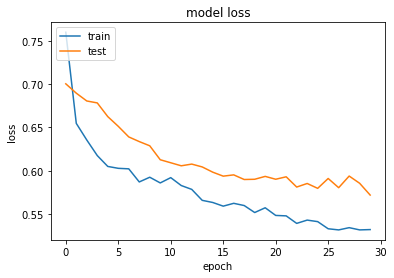

In [ ]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [ ]:
# Saving the model.json

import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [ ]:
saved_model/my_model

In [ ]:
# load weights into new model
loaded_model.load_weights("my_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 75.83%


In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("sequential_9/aug_noiseNshift_2class2_np.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

OSError: Unable to open file (unable to open file: name = 'sequential_9/aug_noiseNshift_2class2_np.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# X. Predicting emotions on the test data

In [ ]:
len(data3_df)

80

In [ ]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data3_df))):
    X, sample_rate = librosa.load(data3_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data3_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:13<00:00,  6.07it/s]


In [ ]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

5/5 [==============================] - 1s 132ms/step


In [ ]:
preds

array([[0.32355005, 0.6764499 ],
       [0.4178418 , 0.5821582 ],
       [0.6272793 , 0.3727207 ],
       [0.39840376, 0.6015962 ],
       [0.40309697, 0.596903  ],
       [0.38934293, 0.61065716],
       [0.34094846, 0.65905154],
       [0.2704792 , 0.7295208 ],
       [0.51940024, 0.4805997 ],
       [0.5102101 , 0.4897899 ],
       [0.5298491 , 0.47015086],
       [0.543399  , 0.45660105],
       [0.55659735, 0.4434027 ],
       [0.55170757, 0.44829237],
       [0.65038776, 0.3496122 ],
       [0.58218974, 0.4178103 ],
       [0.30115744, 0.6988425 ],
       [0.28395966, 0.7160403 ],
       [0.32523832, 0.67476165],
       [0.22114375, 0.7788562 ],
       [0.43811074, 0.5618893 ],
       [0.51391214, 0.48608795],
       [0.36339933, 0.6366007 ],
       [0.3442022 , 0.6557977 ],
       [0.61432415, 0.38567585],
       [0.67445666, 0.3255433 ],
       [0.69661593, 0.30338407],
       [0.7652023 , 0.23479778],
       [0.67763877, 0.32236126],
       [0.71021765, 0.28978232],
       [0.

In [ ]:
preds1=preds.argmax(axis=1)

In [ ]:
preds1

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [ ]:
abc = preds1.astype(int).flatten()

In [ ]:
predictions = (lb.inverse_transform((abc)))

In [ ]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_positive
1,male_positive
2,male_negative
3,male_positive
4,male_positive
5,male_positive
6,male_positive
7,male_positive
8,male_negative
9,male_negative


In [ ]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [ ]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_positive
1,male_positive
2,male_positive
3,male_positive
4,male_positive
5,male_positive
6,male_positive
7,male_positive
8,male_positive
9,male_positive


In [ ]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [ ]:
finaldf[20:40]

,actualvalues,predictedvalues
20,male_negative,male_positive
21,male_negative,male_negative
22,male_negative,male_positive
23,male_negative,male_positive
24,male_negative,male_negative
25,male_negative,male_negative
26,male_negative,male_negative
27,male_negative,male_negative
28,male_negative,male_negative
29,male_negative,male_negative


In [ ]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
male_negative,48
male_positive,32


In [ ]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
male_negative,49
male_positive,31


In [ ]:
finaldf.to_csv('Predictions.csv', index=False)

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [ ]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

58.75

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

56.79921453117329

In [ ]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[32, 16],
       [17, 15]], dtype=int64)

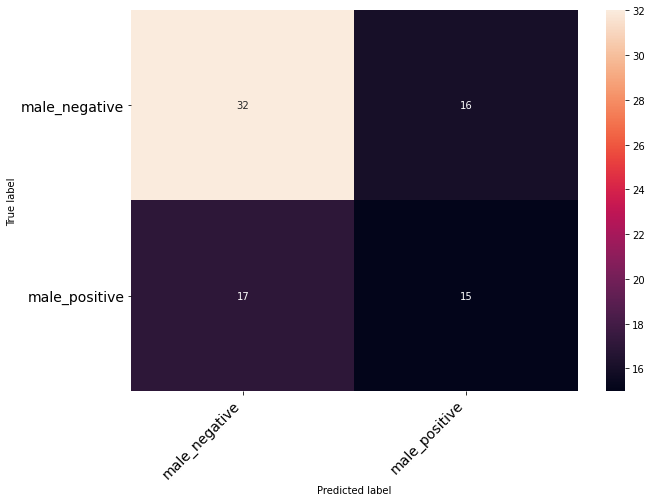

In [ ]:
# Visualize Confusion Matrix 

# class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad']
# class_names = ['male_negative', 'male_neutral', 'male_positive']
class_names = ['male_negative', 'male_positive']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']


print_confusion_matrix(c, class_names)